In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import albumentations as A
import gc

import torch as tch
import torchvision.transforms as trf
from keras.utils import to_categorical
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification ,ConvNextImageProcessor
from transformers import DeiTImageProcessor, DeiTForImageClassificationWithTeacher
from transformers import AutoFeatureExtractor, SwinForImageClassification



from torch.nn.parameter import Parameter
# import torch_xla
# import torch_xla.core.xla_model as xm

device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

In [2]:
train_df = pd.read_csv('../input/drs-retino/train.csv')

In [3]:
contrast_root = '../input/diabetic-retinopathy-train/contrast/contrast/'
enh_root = '../input/diabetic-retinopathy-train/enhance-001/enhance/'
croped_root = '../input/diabetic-retinopathy-train/croped-002/croped/'

# EDA

<AxesSubplot:xlabel='target', ylabel='Count'>

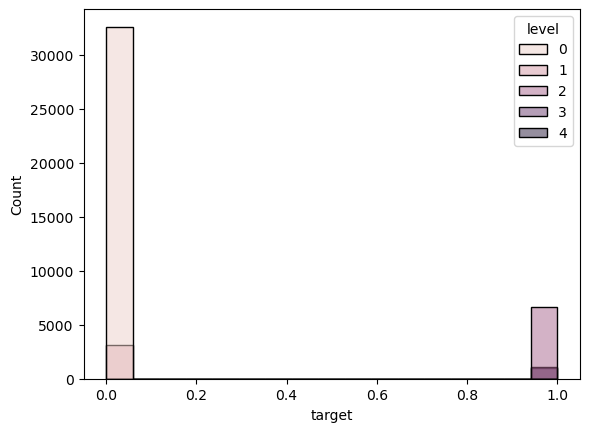

In [4]:
sns.histplot(data = train_df, x = 'target', hue = 'level')

<AxesSubplot:xlabel='level', ylabel='Count'>

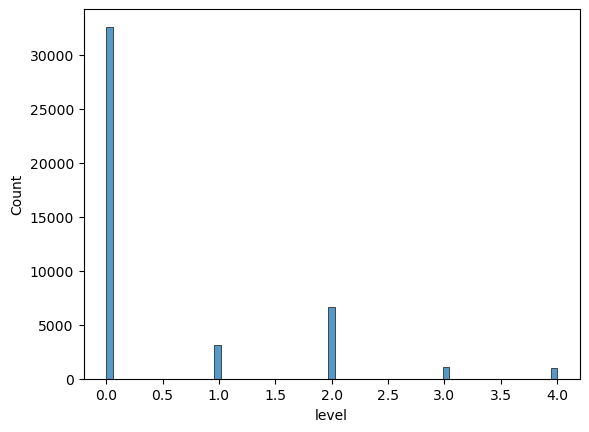

In [5]:
sns.histplot(data = train_df, x = 'level')

In [6]:
print('Target count :')
print( f'Target | 0 | = {train_df[train_df.target == 0].shape[0]} samples' )
print( f'Target | 1 | = {train_df[train_df.target == 1].shape[0]} samples' )
print('-------------------------------')

print('Level count :')
print( f'Level | 0 | = {train_df[train_df.level == 0].shape[0]} samples' )
print( f'Level | 1 | = {train_df[train_df.level == 1].shape[0]} samples' )
print( f'Level | 2 | = {train_df[train_df.level == 2].shape[0]} samples' )
print( f'Level | 3 | = {train_df[train_df.level == 3].shape[0]} samples' )
print( f'Level | 4 | = {train_df[train_df.level == 4].shape[0]} samples' )
print('-------------------------------')
print(f'Total sample : {train_df.shape[0]}')

Target count :
Target | 0 | = 35706 samples
Target | 1 | = 8637 samples
-------------------------------
Level count :
Level | 0 | = 32575 samples
Level | 1 | = 3131 samples
Level | 2 | = 6626 samples
Level | 3 | = 1059 samples
Level | 4 | = 952 samples
-------------------------------
Total sample : 44343


[707 728 608 549]


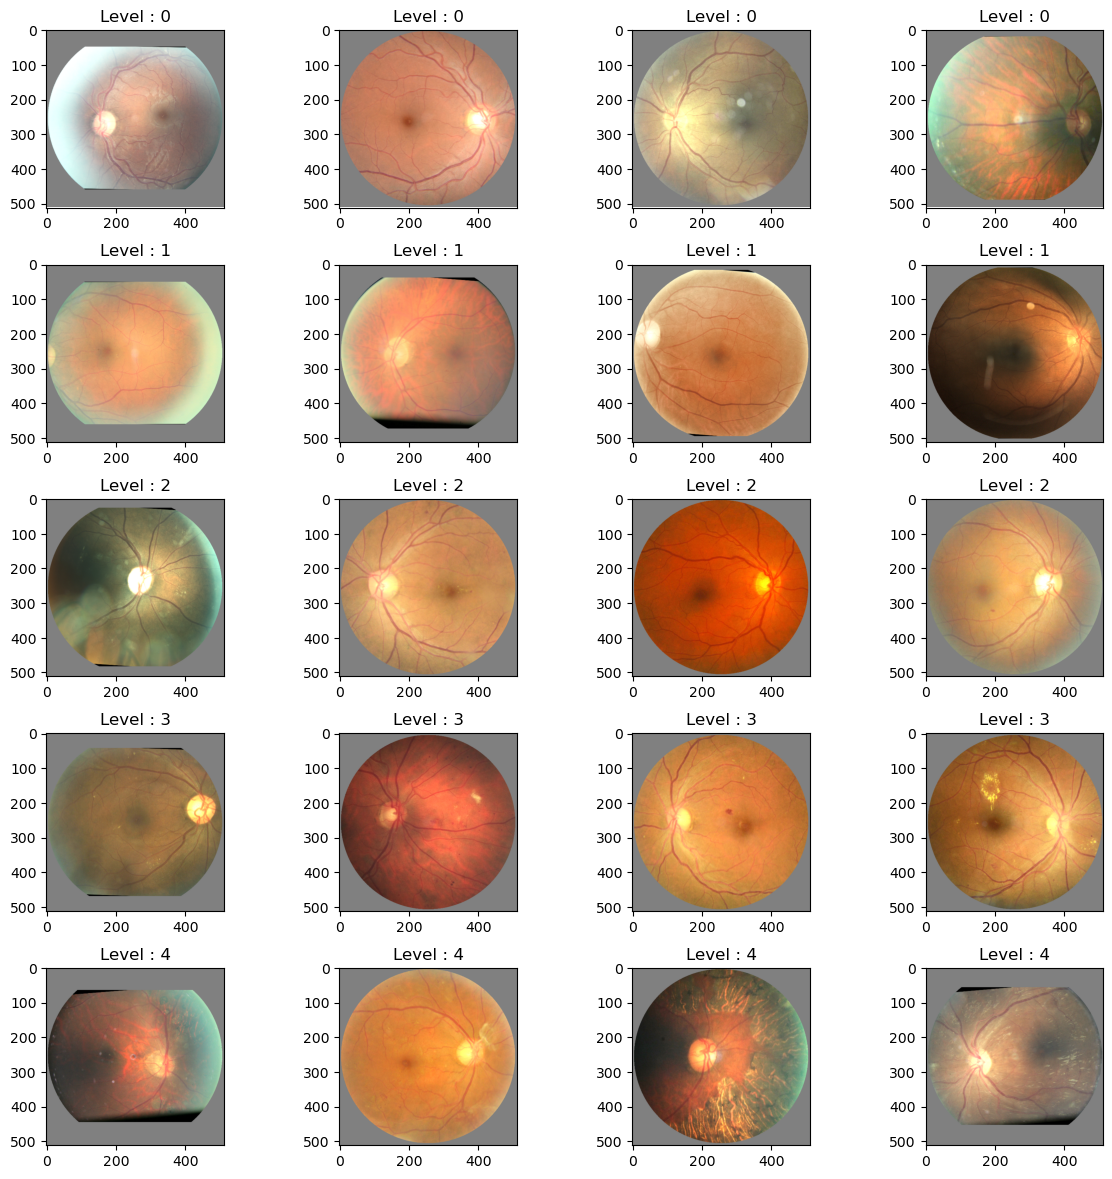

In [7]:
fig_size = (12,12)
rand_arr = np.random.randint(0,952,4)
print(rand_arr)

fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = croped_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

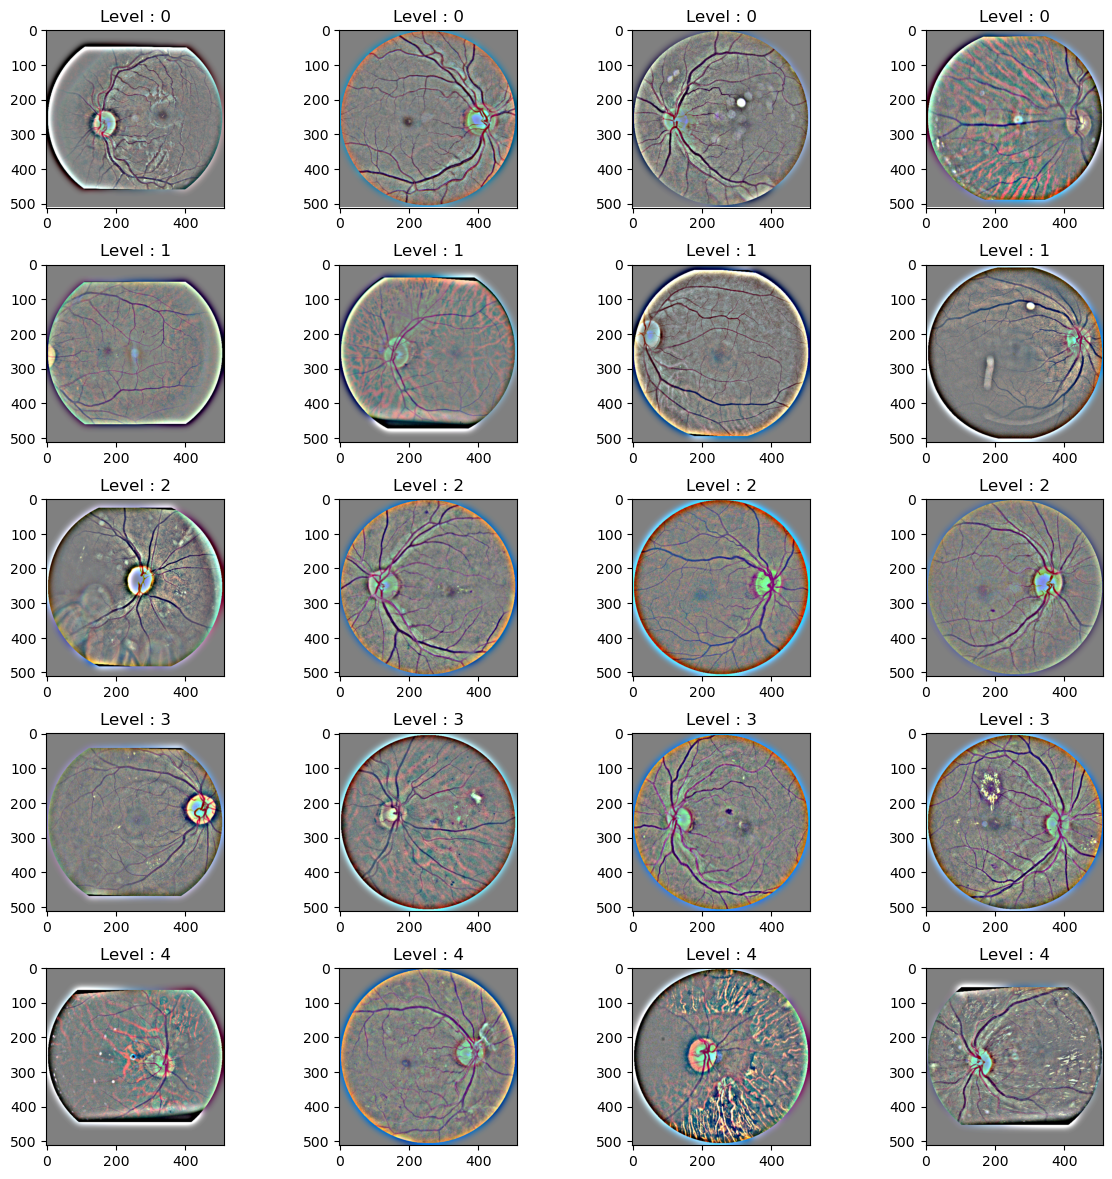

In [8]:

fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = contrast_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

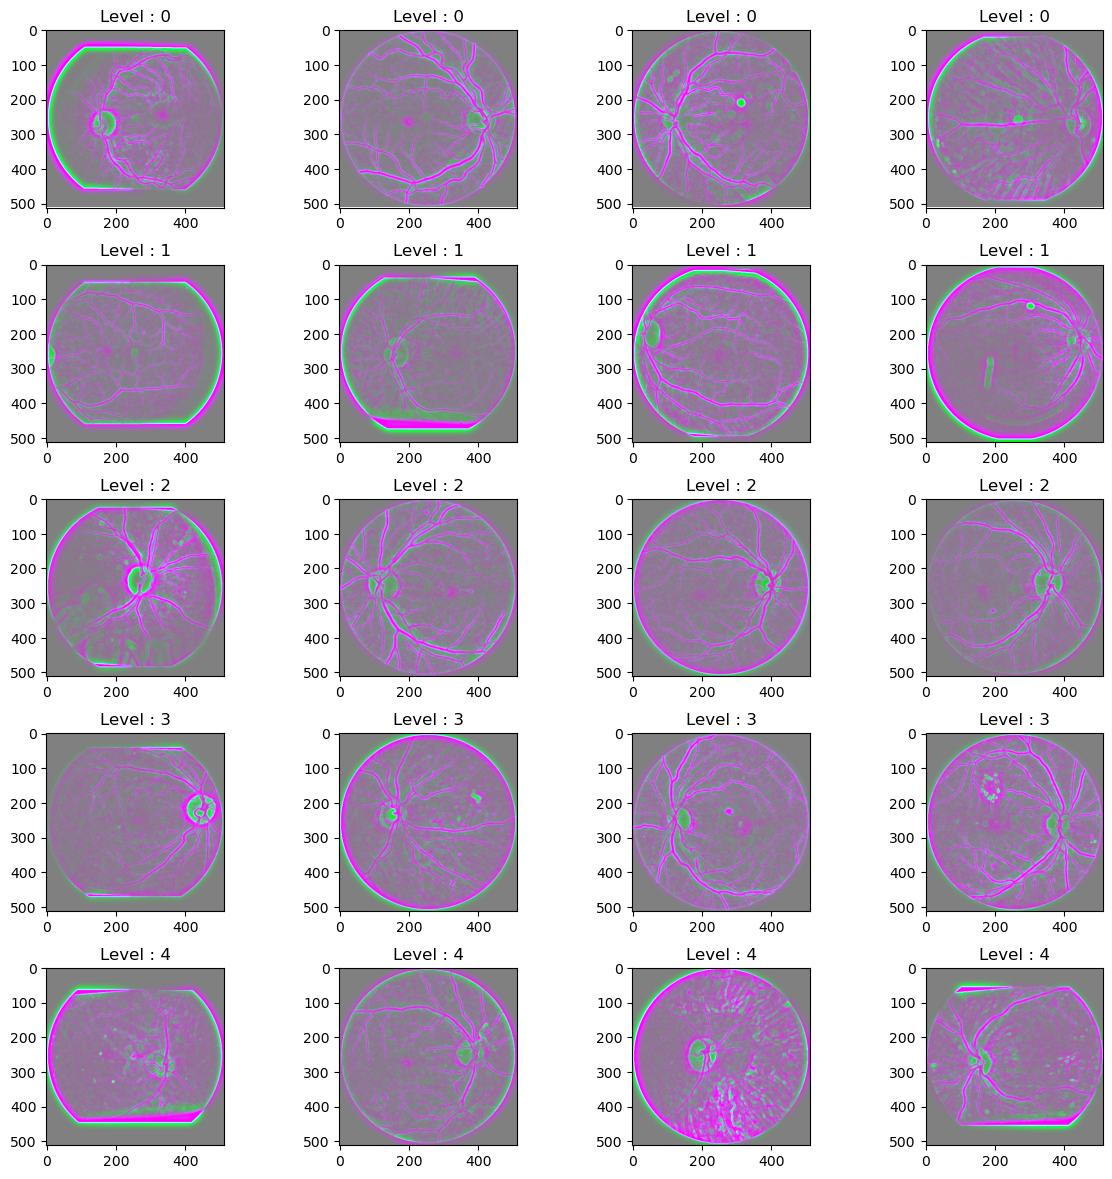

In [9]:
fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = enh_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

<AxesSubplot:xlabel='target', ylabel='Count'>

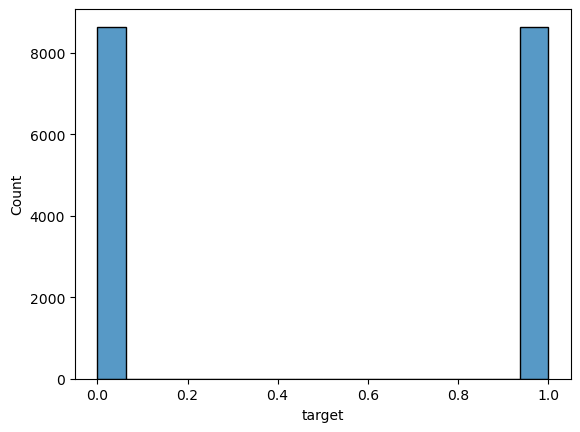

In [10]:
df_archive = []
lowest = 8637
for i in range(train_df.target.nunique()):
    df = train_df[train_df.target == i][:lowest]
    df_archive.append(df)
    
train_df = pd.concat(df_archive)
sns.histplot(data = train_df, x = 'target')

# Train test split

In [11]:
train_df = train_df.sample(frac = 1, random_state = 512).reset_index(drop = True)

In [12]:
df_archive = []

for i in range(train_df.target.nunique()):
    df = train_df[train_df.target == i][:100]
    df_archive.append(df)
    
test = pd.concat(df_archive)

In [13]:
x = pd.concat([train_df,test])
dup = x.duplicated(keep = False)
train = x[~dup]
train = train.sample(frac = 1, random_state = 512).reset_index(drop = True)

In [14]:
train[:50]

filename  level  target
0    im_1937.png      0       0
1   im_21731.png      0       0
2   im_30418.png      4       1
3   im_12531.png      0       0
4   im_15863.png      0       0
5   im_26969.png      1       0
6   im_19409.png      0       0
7   im_29449.png      2       1
8   im_11693.png      1       0
9   im_12469.png      0       0
10  im_10579.png      0       0
11  im_43367.png      2       1
12  im_27677.png      0       0
13  im_54805.png      2       1
14  im_15589.png      0       0
15  im_25194.png      0       0
16  im_79693.png      3       1
17  im_58425.png      2       1
18  im_20181.png      1       0
19  im_24217.png      0       0
20  im_12382.png      0       0
21  im_12514.png      0       0
22  im_14997.png      1       0
23  im_21025.png      0       0
24  im_10866.png      2       1
25  im_21513.png      0       0
26  im_68885.png      2       1
27  im_22452.png      0       0
28  im_88069.png      2       1
29  im_19719.png      0       0
30  im_13198.png      0       0
31  im_41271.png      3       1
32  im_25199.png      0       0
33  im_11228.png      0       0
34  im_21578.png      0       0
35  im_13849.png      0       0
36  im_28726.png      0       0
37  im_24708.png      0       0
38  im_19917.png      0       0
39  im_24716.png      0       0
40  im_20096.png      2       1
41  im_10773.png      0       0
42  im_20373.png      0       0
43  im_12290.png      0       0
44  im_15755.png      0       0
45  im_19413.png      0       0
46  im_11789.png      0       0
47  im_16692.png      0       0
48  im_14036.png      2       1
49  im_23424.png      1       0

# Lion Optimizer

In [15]:
import torch
from torch.optim.optimizer import Optimizer

# functions

def exists(val):
    return val is not None

# update functions

def update_fn(p, grad, exp_avg, lr, wd, beta1, beta2):
    # stepweight decay

    p.data.mul_(1 - lr * wd)

    # weight update

    update = exp_avg.clone().mul_(beta1).add(grad, alpha = 1 - beta1).sign_()
    p.add_(update, alpha = -lr)

    # decay the momentum running average coefficient

    exp_avg.mul_(beta2).add_(grad, alpha = 1 - beta2)

# class

class Lion(Optimizer):
    def __init__(
        self,
        params,
        lr: float = 1e-4,
        betas = (0.9, 0.99),
        weight_decay: float = 0.0,
    ):
        assert lr > 0.
        assert all([0. <= beta <= 1. for beta in betas])

        defaults = dict(
            lr = lr,
            betas = betas,
            weight_decay = weight_decay
        )

        super().__init__(params, defaults)

        self.update_fn = update_fn

    @torch.no_grad()
    def step(
        self,
        closure = None
    ):

        loss = None
        if exists(closure):
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in filter(lambda p: exists(p.grad), group['params']):

                grad, lr, wd, beta1, beta2, state = p.grad, group['lr'], group['weight_decay'], *group['betas'], self.state[p]

                # init state - exponential moving average of gradient values

                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']

                self.update_fn(
                    p,
                    grad,
                    exp_avg,
                    lr,
                    wd,
                    beta1,
                    beta2
                )

        return loss

# Feed batch on fly ------

In [16]:
class BatchFeeder:
    def __init__(self, df,img_size, batch_size, root, transform = None, one_hot = True):
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.root = root
        self.transform = transform
        self.one_hot = one_hot

        
    def feed(self,ib,test_mode = False):
        batchX = []
        batchY = []
        df = self.df[int(ib*self.batch_size):int( (ib*self.batch_size) + self.batch_size )]
        for i in df.iterrows():
            img_path = self.root + i[1][0]
            img_arr = cv2.imread(img_path)
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            img_arr = cv2.resize(img_arr,(self.img_size,self.img_size))
            
            if self.transform:
                img_arr = self.transform( image = img_arr )['image'].astype(np.uint8)
            else:
                transform = A.Compose([
                    A.Normalize()], p = 1.0)
                img_arr = transform( image = img_arr )['image'].astype(np.uint8)
            
            if not test_mode:
                if self.one_hot:
                    batchY.append(to_categorical(i[1][2],num_classes = 2))
                else:
                    batchY.append(i[1][2])
            
            batchX.append(img_arr)
        if not test_mode:
            return tch.from_numpy(np.array(batchX).astype(np.float32)),\
                    tch.from_numpy(np.array(batchY))
        else:
            return tch.from_numpy(np.array(batchX).astype(np.float32))
    
    def pic_div_255(self,img):
        return img / 255
    
    def arr_round(self,img):
        return np.round(img,5)

In [17]:
transform = A.Compose([
#     A.Blur( p = 0.2 ),
#     A.Flip( p = 0.3 ),
#     A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
#     A.ShiftScaleRotate(p = 0.3),
#     A.ElasticTransform( p = 0.3),
#     A.Transpose(p = 0.3),
#     A.GridDistortion(p = 0.3),
#     A.HueSaturationValue(10,10,10,p = 0.3 ),
#     A.CLAHE( p = 0.2 ),
    A.Normalize()], 
    #A.CoarseDropout( p = 0.2 ),],
    p = 1.0)

# Modeling

In [18]:
processor = ViTImageProcessor.from_pretrained('microsoft/swin-tiny-patch4-window7-224')
model = SwinForImageClassification.from_pretrained('microsoft/swin-tiny-patch4-window7-224')

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
model.classifier = tch.nn.Sequential(
    tch.nn.Linear(768,480),
    tch.nn.Linear(480,train_df.target.nunique()),
#     tch.nn.Linear(512,768),
#     tch.nn.ReLU(),
#     tch.nn.Linear(768,512),
#     tch.nn.ReLU(),
#     tch.nn.Linear(512,768),
#     tch.nn.ReLU(),
#     tch.nn.Linear(768,train_df.target.nunique()),
)

#

# model.classifier = tch.nn.Linear(768,train_df.level.nunique())
model= tch.nn.DataParallel(model)
model = model.to(device)

In [21]:
from sklearn.metrics import f1_score

In [22]:
def val_on_batch(model, img_size, batch_size, criterion, size = 0.1):
    df = test[:int(test.shape[0] * size)]
    stepsE = df.shape[0] // batch_size
    val_loss = 0
    val_acc = 0
    f1_val = 0
    for st in range(stepsE):
        model.eval()
        bfd_test = BatchFeeder(df,img_size,batch_size,enh_root).feed(st)
        x_inp = processor(bfd_test[0],return_tensors="pt")
        y_inp = bfd_test[1].to(device)

        with tch.no_grad():
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
#             print( y_inp.argmax(1).cpu().numpy().shape)
            f1_ = f1_score(out.logits.argmax(1).cpu().numpy(), y_inp.argmax(1).cpu().numpy())
            
        f1_val += f1_ / stepsE
        val_loss += loss.item() / stepsE
        val_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
    
    return val_loss,val_acc / df.shape[0],f1_val

In [23]:
train_loss_achv = []
train_acc_achv = []
train_f1_achv = []

val_loss_achv = []
val_acc_achv = []
val_f1_achv = []

In [24]:
def train_model(model,img_size,ep,batch_size,criterion,optimizer,root_dir,unfreeze_steps = 50):
    
    stepsT = train.shape[0] // batch_size
    stepsE = test.shape[0] // batch_size
#     Xtrain.to(device)
#     Xtest.to(device)
#     Ytrain.to(device)
#     Ytest.to(device)
    ###
    best_val = 0
    total_steps = 0
    ###
    for i in range(ep):
        print(f'Ep: {i+1}')
        
        train_loss = 0
        val_loss = 0
        
        train_acc = 0
        val_acc = 0
        
        train_f1 = 0
        val_f1 = 0
        ## Train
        for st in tqdm(range(stepsT)):
            model.train()
            # Prepare the Input
            bfd_train = BatchFeeder(train,img_size,batch_size,root_dir).feed(st)
            
            x_inp = processor(bfd_train[0], return_tensors="pt")
            y_inp = bfd_train[1].to(device)
            
            optimizer.zero_grad()
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
            f1_ = f1_score(out.logits.argmax(1).cpu().numpy(), y_inp.argmax(1).cpu().numpy(), average = 'micro')
            
            loss.backward()
            optimizer.step()
            acc_ = tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
            train_loss += loss.item() / stepsT
            train_acc += acc_
            train_f1 += f1_ / stepsT
            
            train_loss_achv.append(loss.item)
            train_acc_achv.append(acc_/batch_size)
            train_f1_achv.append(f1_)
            
            if (st+1) % 20 == 0:
#                 print('Eval ---------------- Eval')
#                 ls,acc,f1 = val_on_batch(model, img_size, batch_size, criterion)
                print(f'Loss: {loss.item():.4f} | Acc: {train_acc / (st*batch_size):.4f} | F1: {f1_:.4f}')
                
                if loss.item() < best_val:
                    tch.save(model,'/kaggle/working/checkpoint_hof.pth')
                    best_val = ls
            tch.cuda.empty_cache()
            # Unfreeze
#             if total_steps+1 == unfreeze_steps:
#                 print('----------------Unfreezeeeeeeee-------------------')
#                 for p in model.parameters():
#                     p.requires_grad = True
            
#             scheduler.step()
            total_steps += 1
        tch.cuda.empty_cache()
        ## eval
        for st in tqdm(range(stepsE)):
            model.eval()
            # Prepare the Input
            bfd_test = BatchFeeder(test,img_size,batch_size,root_dir).feed(st)
            
            x_inp = processor(bfd_test[0],return_tensors="pt")
            y_inp = bfd_test[1].to(device)
            
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
            
            f1_ = f1_score(out.logits.argmax(1).cpu().numpy(), y_inp.argmax(1).cpu().numpy(), average = 'micro')
            val_f1 += f1_ / stepsE
            val_loss += loss.item() / stepsE
            val_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
            
            val_loss_achv.append(loss.item)
            val_acc_achv.append(tch.sum(out.logits.argmax(1) == y_inp.argmax(1)) / batch_size)
            val_f1_achv.append(f1_)
            
        tch.save(model,'/kaggle/working/checkpoint.pth')    
        print(f'Train loss: {train_loss:.4f} | Train acc: {(train_acc / train.shape[0]):.4f}')
        print(f'Val loss: {val_loss:.4f} | Val acc: {(val_acc / test.shape[0]):.4f}')
        print(f'Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}')

In [25]:
criterion = tch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = tch.optim.Adam(model.parameters(), lr=1e-5)
optimizer = Lion(model.parameters(), lr=1e-5, weight_decay=1e-2)

# # Decay LR by a factor of 0.1 every 7 epochs
# scheduler = tch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [26]:
train_model(model,224,5,10,criterion,optimizer,croped_root,10)

Ep: 1


  1%|          | 20/1707 [00:15<08:57,  3.14it/s]

Loss: 0.6659 | Acc: 0.4842 | F1: 0.6000


  2%|▏         | 40/1707 [00:21<08:35,  3.23it/s]

Loss: 0.6857 | Acc: 0.5000 | F1: 0.7000


  4%|▎         | 60/1707 [00:27<08:51,  3.10it/s]

Loss: 0.7473 | Acc: 0.4949 | F1: 0.2000


  5%|▍         | 80/1707 [00:34<09:32,  2.84it/s]

Loss: 0.6683 | Acc: 0.4975 | F1: 0.6000


  6%|▌         | 100/1707 [00:40<08:19,  3.22it/s]

Loss: 0.6384 | Acc: 0.5020 | F1: 0.7000


  7%|▋         | 120/1707 [00:47<08:15,  3.21it/s]

Loss: 0.6984 | Acc: 0.5017 | F1: 0.6000


  8%|▊         | 140/1707 [00:53<08:06,  3.22it/s]

Loss: 0.6940 | Acc: 0.5079 | F1: 0.5000


  9%|▉         | 160/1707 [00:59<08:21,  3.08it/s]

Loss: 0.6795 | Acc: 0.5101 | F1: 0.5000


 11%|█         | 180/1707 [01:06<08:03,  3.16it/s]

Loss: 0.6972 | Acc: 0.5140 | F1: 0.7000


 12%|█▏        | 200/1707 [01:12<09:06,  2.76it/s]

Loss: 0.6251 | Acc: 0.5166 | F1: 0.7000


 13%|█▎        | 220/1707 [01:19<07:56,  3.12it/s]

Loss: 0.7836 | Acc: 0.5183 | F1: 0.3000


 14%|█▍        | 240/1707 [01:25<07:42,  3.17it/s]

Loss: 0.7070 | Acc: 0.5218 | F1: 0.5000


 15%|█▌        | 260/1707 [01:32<07:40,  3.14it/s]

Loss: 0.6176 | Acc: 0.5247 | F1: 0.7000


 16%|█▋        | 280/1707 [01:38<07:31,  3.16it/s]

Loss: 0.6947 | Acc: 0.5258 | F1: 0.7000


 18%|█▊        | 300/1707 [01:45<09:07,  2.57it/s]

Loss: 0.8880 | Acc: 0.5294 | F1: 0.1000


 19%|█▊        | 320/1707 [01:51<07:15,  3.19it/s]

Loss: 0.7819 | Acc: 0.5335 | F1: 0.5000


 20%|█▉        | 340/1707 [01:57<07:22,  3.09it/s]

Loss: 0.7158 | Acc: 0.5322 | F1: 0.4000


 21%|██        | 360/1707 [02:04<07:15,  3.10it/s]

Loss: 0.5816 | Acc: 0.5337 | F1: 0.7000


 22%|██▏       | 380/1707 [02:10<07:07,  3.10it/s]

Loss: 0.6969 | Acc: 0.5354 | F1: 0.6000


 23%|██▎       | 400/1707 [02:17<07:45,  2.81it/s]

Loss: 0.7460 | Acc: 0.5346 | F1: 0.4000


 25%|██▍       | 420/1707 [02:23<06:49,  3.14it/s]

Loss: 0.7944 | Acc: 0.5389 | F1: 0.4000


 26%|██▌       | 440/1707 [02:30<07:02,  3.00it/s]

Loss: 0.6516 | Acc: 0.5367 | F1: 0.6000


 27%|██▋       | 460/1707 [02:36<06:32,  3.18it/s]

Loss: 0.7703 | Acc: 0.5368 | F1: 0.7000


 28%|██▊       | 480/1707 [02:43<06:35,  3.10it/s]

Loss: 0.6708 | Acc: 0.5388 | F1: 0.7000


 29%|██▉       | 500/1707 [02:49<06:41,  3.01it/s]

Loss: 0.6108 | Acc: 0.5411 | F1: 0.7000


 30%|███       | 520/1707 [02:56<06:15,  3.16it/s]

Loss: 0.6678 | Acc: 0.5414 | F1: 0.6000


 32%|███▏      | 540/1707 [03:02<06:17,  3.09it/s]

Loss: 0.7288 | Acc: 0.5440 | F1: 0.6000


 33%|███▎      | 560/1707 [03:08<06:01,  3.17it/s]

Loss: 0.6621 | Acc: 0.5451 | F1: 0.7000


 34%|███▍      | 580/1707 [03:15<05:55,  3.17it/s]

Loss: 0.6605 | Acc: 0.5478 | F1: 0.7000


 35%|███▌      | 600/1707 [03:21<05:52,  3.14it/s]

Loss: 0.6391 | Acc: 0.5487 | F1: 0.5000


 36%|███▋      | 620/1707 [03:28<05:49,  3.11it/s]

Loss: 0.7916 | Acc: 0.5485 | F1: 0.3000


 37%|███▋      | 640/1707 [03:34<05:53,  3.02it/s]

Loss: 0.6082 | Acc: 0.5468 | F1: 0.7000


 39%|███▊      | 660/1707 [03:41<05:31,  3.16it/s]

Loss: 0.6115 | Acc: 0.5454 | F1: 0.8000


 40%|███▉      | 680/1707 [03:47<05:25,  3.16it/s]

Loss: 0.7731 | Acc: 0.5445 | F1: 0.3000


 41%|████      | 700/1707 [03:54<05:23,  3.11it/s]

Loss: 0.7359 | Acc: 0.5443 | F1: 0.6000


 42%|████▏     | 720/1707 [04:01<05:17,  3.11it/s]

Loss: 0.6239 | Acc: 0.5452 | F1: 0.6000


 43%|████▎     | 740/1707 [04:07<05:25,  2.97it/s]

Loss: 0.5739 | Acc: 0.5459 | F1: 0.9000


 45%|████▍     | 760/1707 [04:14<05:15,  3.00it/s]

Loss: 0.7574 | Acc: 0.5457 | F1: 0.6000


 46%|████▌     | 780/1707 [04:20<05:19,  2.90it/s]

Loss: 0.6877 | Acc: 0.5479 | F1: 0.6000


 47%|████▋     | 800/1707 [04:27<04:48,  3.15it/s]

Loss: 0.6430 | Acc: 0.5484 | F1: 0.7000


 48%|████▊     | 820/1707 [04:33<04:45,  3.11it/s]

Loss: 0.7211 | Acc: 0.5491 | F1: 0.4000


 49%|████▉     | 840/1707 [04:40<04:38,  3.11it/s]

Loss: 0.5869 | Acc: 0.5493 | F1: 0.7000


 50%|█████     | 860/1707 [04:46<04:26,  3.18it/s]

Loss: 0.6312 | Acc: 0.5508 | F1: 0.7000


 52%|█████▏    | 880/1707 [04:53<05:04,  2.72it/s]

Loss: 0.7479 | Acc: 0.5504 | F1: 0.4000


 53%|█████▎    | 900/1707 [04:59<04:21,  3.09it/s]

Loss: 0.6503 | Acc: 0.5509 | F1: 0.7000


 54%|█████▍    | 920/1707 [05:06<04:04,  3.21it/s]

Loss: 0.5994 | Acc: 0.5510 | F1: 0.8000


 55%|█████▌    | 940/1707 [05:12<04:07,  3.10it/s]

Loss: 0.6489 | Acc: 0.5512 | F1: 0.6000


 56%|█████▌    | 960/1707 [05:18<03:59,  3.12it/s]

Loss: 0.7118 | Acc: 0.5503 | F1: 0.4000


 57%|█████▋    | 980/1707 [05:25<04:18,  2.82it/s]

Loss: 0.6880 | Acc: 0.5509 | F1: 0.6000


 59%|█████▊    | 1000/1707 [05:31<03:42,  3.17it/s]

Loss: 0.7228 | Acc: 0.5511 | F1: 0.4000


 60%|█████▉    | 1020/1707 [05:38<03:36,  3.17it/s]

Loss: 0.6734 | Acc: 0.5511 | F1: 0.5000


 61%|██████    | 1040/1707 [05:44<03:32,  3.14it/s]

Loss: 0.5917 | Acc: 0.5524 | F1: 0.7000


 62%|██████▏   | 1060/1707 [05:51<03:25,  3.15it/s]

Loss: 0.6988 | Acc: 0.5518 | F1: 0.5000


 63%|██████▎   | 1080/1707 [05:57<03:32,  2.95it/s]

Loss: 0.6722 | Acc: 0.5519 | F1: 0.7000


 64%|██████▍   | 1100/1707 [06:04<03:24,  2.96it/s]

Loss: 0.7320 | Acc: 0.5523 | F1: 0.6000


 66%|██████▌   | 1120/1707 [06:11<03:07,  3.13it/s]

Loss: 0.7213 | Acc: 0.5527 | F1: 0.4000


 67%|██████▋   | 1140/1707 [06:17<03:03,  3.09it/s]

Loss: 0.7366 | Acc: 0.5535 | F1: 0.6000


 68%|██████▊   | 1160/1707 [06:24<02:56,  3.10it/s]

Loss: 0.6578 | Acc: 0.5535 | F1: 0.7000


 69%|██████▉   | 1180/1707 [06:31<02:52,  3.06it/s]

Loss: 0.6509 | Acc: 0.5547 | F1: 0.7000


 70%|███████   | 1200/1707 [06:37<02:39,  3.18it/s]

Loss: 0.6398 | Acc: 0.5545 | F1: 0.7000


 71%|███████▏  | 1220/1707 [06:43<02:36,  3.11it/s]

Loss: 0.5362 | Acc: 0.5543 | F1: 0.9000


 73%|███████▎  | 1240/1707 [06:50<02:26,  3.18it/s]

Loss: 0.6806 | Acc: 0.5546 | F1: 0.6000


 74%|███████▍  | 1260/1707 [06:56<02:22,  3.15it/s]

Loss: 0.5594 | Acc: 0.5546 | F1: 0.8000


 75%|███████▍  | 1280/1707 [07:03<02:16,  3.13it/s]

Loss: 0.5907 | Acc: 0.5546 | F1: 0.7000


 76%|███████▌  | 1300/1707 [07:09<02:14,  3.03it/s]

Loss: 0.5365 | Acc: 0.5549 | F1: 0.8000


 77%|███████▋  | 1320/1707 [07:16<02:05,  3.08it/s]

Loss: 0.7039 | Acc: 0.5552 | F1: 0.5000


 79%|███████▊  | 1340/1707 [07:22<01:57,  3.13it/s]

Loss: 0.5926 | Acc: 0.5553 | F1: 0.6000


 80%|███████▉  | 1360/1707 [07:29<02:01,  2.86it/s]

Loss: 0.7837 | Acc: 0.5557 | F1: 0.4000


 81%|████████  | 1380/1707 [07:35<01:43,  3.15it/s]

Loss: 0.6083 | Acc: 0.5547 | F1: 0.7000


 82%|████████▏ | 1400/1707 [07:42<01:59,  2.58it/s]

Loss: 0.7694 | Acc: 0.5543 | F1: 0.2000


 83%|████████▎ | 1420/1707 [07:49<01:34,  3.05it/s]

Loss: 0.6332 | Acc: 0.5546 | F1: 0.6000


 84%|████████▍ | 1440/1707 [07:55<01:25,  3.13it/s]

Loss: 0.6204 | Acc: 0.5548 | F1: 0.7000


 86%|████████▌ | 1460/1707 [08:02<01:23,  2.94it/s]

Loss: 0.5406 | Acc: 0.5548 | F1: 0.8000


 87%|████████▋ | 1480/1707 [08:09<01:14,  3.06it/s]

Loss: 0.5648 | Acc: 0.5548 | F1: 0.7000


 88%|████████▊ | 1500/1707 [08:15<01:09,  2.99it/s]

Loss: 0.6651 | Acc: 0.5546 | F1: 0.5000


 89%|████████▉ | 1520/1707 [08:22<00:58,  3.19it/s]

Loss: 0.6851 | Acc: 0.5550 | F1: 0.6000


 90%|█████████ | 1540/1707 [08:28<00:52,  3.16it/s]

Loss: 0.5802 | Acc: 0.5548 | F1: 0.7000


 91%|█████████▏| 1560/1707 [08:35<00:47,  3.13it/s]

Loss: 0.6591 | Acc: 0.5550 | F1: 0.5000


 93%|█████████▎| 1580/1707 [08:41<00:40,  3.11it/s]

Loss: 0.6404 | Acc: 0.5556 | F1: 0.7000


 94%|█████████▎| 1600/1707 [08:48<00:34,  3.08it/s]

Loss: 0.7347 | Acc: 0.5552 | F1: 0.2000


 95%|█████████▍| 1620/1707 [08:54<00:28,  3.10it/s]

Loss: 0.7374 | Acc: 0.5550 | F1: 0.3000


 96%|█████████▌| 1640/1707 [09:01<00:21,  3.12it/s]

Loss: 0.7413 | Acc: 0.5549 | F1: 0.5000


 97%|█████████▋| 1660/1707 [09:08<00:15,  3.04it/s]

Loss: 0.6093 | Acc: 0.5560 | F1: 0.8000


 98%|█████████▊| 1680/1707 [09:14<00:08,  3.10it/s]

Loss: 0.6997 | Acc: 0.5565 | F1: 0.6000


100%|█████████▉| 1700/1707 [09:21<00:02,  3.10it/s]

Loss: 0.6697 | Acc: 0.5571 | F1: 0.4000


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Train loss: 0.6821 | Train acc: 0.5567
Val loss: 0.6846 | Val acc: 0.5700
Train F1: 0.5568 | Val F1: 0.5700
Ep: 2


  1%|          | 20/1707 [00:05<08:26,  3.33it/s]

Loss: 0.6361 | Acc: 0.5842 | F1: 0.7000


  2%|▏         | 40/1707 [00:10<07:09,  3.88it/s]

Loss: 0.6239 | Acc: 0.5615 | F1: 0.8000


  4%|▎         | 60/1707 [00:15<06:55,  3.97it/s]

Loss: 0.6317 | Acc: 0.5763 | F1: 0.6000


  5%|▍         | 80/1707 [00:20<06:48,  3.99it/s]

Loss: 0.6265 | Acc: 0.5734 | F1: 0.6000


  6%|▌         | 100/1707 [00:26<06:40,  4.01it/s]

Loss: 0.6664 | Acc: 0.5626 | F1: 0.5000


  7%|▋         | 120/1707 [00:31<07:08,  3.70it/s]

Loss: 0.7216 | Acc: 0.5613 | F1: 0.4000


  8%|▊         | 140/1707 [00:36<07:29,  3.48it/s]

Loss: 0.7715 | Acc: 0.5604 | F1: 0.6000


  9%|▉         | 160/1707 [00:41<06:48,  3.79it/s]

Loss: 0.6670 | Acc: 0.5560 | F1: 0.5000


 11%|█         | 180/1707 [00:47<06:46,  3.76it/s]

Loss: 0.6308 | Acc: 0.5564 | F1: 0.5000


 12%|█▏        | 200/1707 [00:52<06:42,  3.75it/s]

Loss: 0.5668 | Acc: 0.5558 | F1: 0.9000


 13%|█▎        | 220/1707 [00:57<06:20,  3.91it/s]

Loss: 0.7714 | Acc: 0.5598 | F1: 0.6000


 14%|█▍        | 240/1707 [01:02<06:10,  3.96it/s]

Loss: 0.6145 | Acc: 0.5598 | F1: 0.7000


 15%|█▌        | 260/1707 [01:07<06:03,  3.98it/s]

Loss: 0.5656 | Acc: 0.5618 | F1: 0.7000


 16%|█▋        | 280/1707 [01:13<06:09,  3.86it/s]

Loss: 0.7423 | Acc: 0.5649 | F1: 0.5000


 18%|█▊        | 300/1707 [01:18<05:47,  4.05it/s]

Loss: 0.8103 | Acc: 0.5652 | F1: 0.2000


 19%|█▊        | 320/1707 [01:23<05:46,  4.00it/s]

Loss: 0.7191 | Acc: 0.5652 | F1: 0.6000


 20%|█▉        | 340/1707 [01:28<05:50,  3.90it/s]

Loss: 0.5986 | Acc: 0.5652 | F1: 0.8000


 21%|██        | 360/1707 [01:33<05:39,  3.96it/s]

Loss: 0.6334 | Acc: 0.5671 | F1: 0.6000


 22%|██▏       | 380/1707 [01:38<05:52,  3.77it/s]

Loss: 0.6751 | Acc: 0.5683 | F1: 0.5000


 23%|██▎       | 400/1707 [01:44<06:18,  3.45it/s]

Loss: 0.6843 | Acc: 0.5672 | F1: 0.5000


 25%|██▍       | 420/1707 [01:50<05:36,  3.82it/s]

Loss: 0.7513 | Acc: 0.5702 | F1: 0.6000


 26%|██▌       | 440/1707 [01:55<05:18,  3.98it/s]

Loss: 0.6303 | Acc: 0.5699 | F1: 0.5000


 27%|██▋       | 460/1707 [02:00<05:19,  3.90it/s]

Loss: 0.7917 | Acc: 0.5678 | F1: 0.5000


 28%|██▊       | 480/1707 [02:05<05:04,  4.03it/s]

Loss: 0.6656 | Acc: 0.5676 | F1: 0.5000


 29%|██▉       | 500/1707 [02:10<05:14,  3.84it/s]

Loss: 0.6925 | Acc: 0.5707 | F1: 0.4000


 30%|███       | 520/1707 [02:15<04:50,  4.08it/s]

Loss: 0.6375 | Acc: 0.5713 | F1: 0.5000


 32%|███▏      | 540/1707 [02:20<05:01,  3.88it/s]

Loss: 0.6678 | Acc: 0.5718 | F1: 0.6000


 33%|███▎      | 560/1707 [02:25<04:43,  4.05it/s]

Loss: 0.6441 | Acc: 0.5730 | F1: 0.7000


 34%|███▍      | 580/1707 [02:30<04:37,  4.06it/s]

Loss: 0.6463 | Acc: 0.5750 | F1: 0.6000


 35%|███▌      | 600/1707 [02:36<04:35,  4.01it/s]

Loss: 0.5944 | Acc: 0.5761 | F1: 0.9000


 36%|███▋      | 620/1707 [02:41<04:43,  3.84it/s]

Loss: 0.8711 | Acc: 0.5746 | F1: 0.2000


 37%|███▋      | 640/1707 [02:46<04:27,  3.99it/s]

Loss: 0.5662 | Acc: 0.5729 | F1: 0.8000


 39%|███▊      | 660/1707 [02:51<04:31,  3.86it/s]

Loss: 0.6133 | Acc: 0.5725 | F1: 0.8000


 40%|███▉      | 680/1707 [02:57<04:21,  3.92it/s]

Loss: 0.8470 | Acc: 0.5726 | F1: 0.4000


 41%|████      | 700/1707 [03:02<04:12,  3.98it/s]

Loss: 0.6897 | Acc: 0.5722 | F1: 0.5000


 42%|████▏     | 720/1707 [03:07<04:09,  3.96it/s]

Loss: 0.6524 | Acc: 0.5718 | F1: 0.6000


 43%|████▎     | 740/1707 [03:12<04:08,  3.89it/s]

Loss: 0.5296 | Acc: 0.5714 | F1: 0.9000


 45%|████▍     | 760/1707 [03:18<04:51,  3.25it/s]

Loss: 0.7205 | Acc: 0.5718 | F1: 0.6000


 46%|████▌     | 780/1707 [03:23<03:51,  4.00it/s]

Loss: 0.6701 | Acc: 0.5728 | F1: 0.7000


 47%|████▋     | 800/1707 [03:28<03:51,  3.92it/s]

Loss: 0.6979 | Acc: 0.5721 | F1: 0.6000


 48%|████▊     | 820/1707 [03:33<03:41,  4.01it/s]

Loss: 0.7455 | Acc: 0.5724 | F1: 0.5000


 49%|████▉     | 840/1707 [03:38<03:39,  3.95it/s]

Loss: 0.6148 | Acc: 0.5726 | F1: 0.5000


 50%|█████     | 860/1707 [03:43<03:37,  3.89it/s]

Loss: 0.7119 | Acc: 0.5735 | F1: 0.6000


 52%|█████▏    | 880/1707 [03:49<03:33,  3.87it/s]

Loss: 0.8186 | Acc: 0.5737 | F1: 0.3000


 53%|█████▎    | 900/1707 [03:54<03:18,  4.07it/s]

Loss: 0.6516 | Acc: 0.5744 | F1: 0.7000


 54%|█████▍    | 920/1707 [03:59<03:37,  3.61it/s]

Loss: 0.6414 | Acc: 0.5750 | F1: 0.6000


 55%|█████▌    | 940/1707 [04:04<03:13,  3.97it/s]

Loss: 0.6731 | Acc: 0.5745 | F1: 0.5000


 56%|█████▌    | 960/1707 [04:09<03:07,  3.99it/s]

Loss: 0.6560 | Acc: 0.5734 | F1: 0.6000


 57%|█████▋    | 980/1707 [04:14<03:09,  3.84it/s]

Loss: 0.7354 | Acc: 0.5723 | F1: 0.3000


 59%|█████▊    | 1000/1707 [04:20<03:00,  3.92it/s]

Loss: 0.6146 | Acc: 0.5731 | F1: 0.6000


 60%|█████▉    | 1020/1707 [04:25<02:50,  4.02it/s]

Loss: 0.6419 | Acc: 0.5727 | F1: 0.6000


 61%|██████    | 1040/1707 [04:30<02:54,  3.82it/s]

Loss: 0.6156 | Acc: 0.5736 | F1: 0.7000


 62%|██████▏   | 1060/1707 [04:35<02:43,  3.96it/s]

Loss: 0.6658 | Acc: 0.5729 | F1: 0.7000


 63%|██████▎   | 1080/1707 [04:40<02:40,  3.90it/s]

Loss: 0.6805 | Acc: 0.5722 | F1: 0.6000


 64%|██████▍   | 1100/1707 [04:45<02:32,  3.97it/s]

Loss: 0.6705 | Acc: 0.5727 | F1: 0.5000


 66%|██████▌   | 1120/1707 [04:51<02:31,  3.88it/s]

Loss: 0.7271 | Acc: 0.5729 | F1: 0.4000


 67%|██████▋   | 1140/1707 [04:56<02:22,  3.97it/s]

Loss: 0.6457 | Acc: 0.5737 | F1: 0.6000


 68%|██████▊   | 1160/1707 [05:01<02:13,  4.10it/s]

Loss: 0.5885 | Acc: 0.5741 | F1: 0.7000


 69%|██████▉   | 1180/1707 [05:06<02:20,  3.75it/s]

Loss: 0.6172 | Acc: 0.5750 | F1: 0.7000


 70%|███████   | 1200/1707 [05:11<02:19,  3.63it/s]

Loss: 0.6429 | Acc: 0.5753 | F1: 0.6000


 71%|███████▏  | 1220/1707 [05:16<02:06,  3.86it/s]

Loss: 0.5691 | Acc: 0.5757 | F1: 0.7000


 73%|███████▎  | 1240/1707 [05:22<02:00,  3.86it/s]

Loss: 0.6109 | Acc: 0.5755 | F1: 0.7000


 74%|███████▍  | 1260/1707 [05:26<01:50,  4.06it/s]

Loss: 0.6588 | Acc: 0.5758 | F1: 0.6000


 75%|███████▍  | 1280/1707 [05:32<01:47,  3.98it/s]

Loss: 0.6422 | Acc: 0.5754 | F1: 0.6000


 76%|███████▌  | 1300/1707 [05:37<01:41,  4.00it/s]

Loss: 0.5553 | Acc: 0.5751 | F1: 0.7000


 77%|███████▋  | 1320/1707 [05:42<01:48,  3.58it/s]

Loss: 0.6566 | Acc: 0.5752 | F1: 0.4000


 79%|███████▊  | 1340/1707 [05:47<01:31,  4.02it/s]

Loss: 0.5646 | Acc: 0.5753 | F1: 0.6000


 80%|███████▉  | 1360/1707 [05:52<01:30,  3.83it/s]

Loss: 0.6583 | Acc: 0.5755 | F1: 0.6000


 81%|████████  | 1380/1707 [05:57<01:20,  4.06it/s]

Loss: 0.6680 | Acc: 0.5746 | F1: 0.5000


 82%|████████▏ | 1400/1707 [06:03<01:18,  3.92it/s]

Loss: 0.7195 | Acc: 0.5746 | F1: 0.5000


 83%|████████▎ | 1420/1707 [06:07<01:08,  4.16it/s]

Loss: 0.6053 | Acc: 0.5746 | F1: 0.5000


 84%|████████▍ | 1440/1707 [06:13<01:09,  3.82it/s]

Loss: 0.5964 | Acc: 0.5748 | F1: 0.6000


 86%|████████▌ | 1460/1707 [06:18<01:00,  4.06it/s]

Loss: 0.5658 | Acc: 0.5755 | F1: 1.0000


 87%|████████▋ | 1480/1707 [06:23<01:08,  3.33it/s]

Loss: 0.5943 | Acc: 0.5755 | F1: 0.6000


 88%|████████▊ | 1500/1707 [06:28<00:50,  4.07it/s]

Loss: 0.6185 | Acc: 0.5749 | F1: 0.5000


 89%|████████▉ | 1520/1707 [06:33<00:50,  3.73it/s]

Loss: 0.6715 | Acc: 0.5752 | F1: 0.6000


 90%|█████████ | 1540/1707 [06:38<00:41,  4.02it/s]

Loss: 0.5902 | Acc: 0.5750 | F1: 0.9000


 91%|█████████▏| 1560/1707 [06:43<00:41,  3.57it/s]

Loss: 0.5469 | Acc: 0.5743 | F1: 0.7000


 93%|█████████▎| 1580/1707 [06:48<00:30,  4.11it/s]

Loss: 0.6119 | Acc: 0.5745 | F1: 0.7000


 94%|█████████▎| 1600/1707 [06:54<00:32,  3.32it/s]

Loss: 0.6657 | Acc: 0.5743 | F1: 0.6000


 95%|█████████▍| 1620/1707 [06:59<00:21,  4.01it/s]

Loss: 0.7186 | Acc: 0.5744 | F1: 0.4000


 96%|█████████▌| 1640/1707 [07:04<00:16,  4.09it/s]

Loss: 0.7825 | Acc: 0.5736 | F1: 0.4000


 97%|█████████▋| 1660/1707 [07:09<00:11,  4.11it/s]

Loss: 0.5762 | Acc: 0.5737 | F1: 0.8000


 98%|█████████▊| 1680/1707 [07:14<00:07,  3.69it/s]

Loss: 0.7149 | Acc: 0.5736 | F1: 0.5000


100%|█████████▉| 1700/1707 [07:19<00:01,  4.02it/s]

Loss: 0.7347 | Acc: 0.5736 | F1: 0.3000


100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


Train loss: 0.6732 | Train acc: 0.5733
Val loss: 0.6956 | Val acc: 0.5600
Train F1: 0.5735 | Val F1: 0.5600
Ep: 3


  1%|          | 20/1707 [00:06<08:09,  3.45it/s]

Loss: 0.6433 | Acc: 0.5421 | F1: 0.8000


  2%|▏         | 40/1707 [00:11<07:56,  3.50it/s]

Loss: 0.5954 | Acc: 0.5615 | F1: 0.8000


  4%|▎         | 60/1707 [00:17<07:50,  3.50it/s]

Loss: 0.6752 | Acc: 0.5831 | F1: 0.6000


  5%|▍         | 80/1707 [00:23<07:50,  3.45it/s]

Loss: 0.6171 | Acc: 0.5899 | F1: 0.7000


  6%|▌         | 100/1707 [00:29<07:26,  3.60it/s]

Loss: 0.6461 | Acc: 0.5838 | F1: 0.6000


  7%|▋         | 120/1707 [00:35<08:12,  3.22it/s]

Loss: 0.7474 | Acc: 0.5815 | F1: 0.4000


  8%|▊         | 140/1707 [00:40<07:12,  3.63it/s]

Loss: 0.6933 | Acc: 0.5763 | F1: 0.5000


  9%|▉         | 160/1707 [00:46<07:23,  3.48it/s]

Loss: 0.6253 | Acc: 0.5723 | F1: 0.6000


 11%|█         | 180/1707 [00:52<07:11,  3.54it/s]

Loss: 0.6571 | Acc: 0.5732 | F1: 0.6000


 12%|█▏        | 200/1707 [00:57<07:13,  3.47it/s]

Loss: 0.5936 | Acc: 0.5724 | F1: 0.6000


 13%|█▎        | 220/1707 [01:03<07:02,  3.52it/s]

Loss: 0.8100 | Acc: 0.5813 | F1: 0.5000


 14%|█▍        | 240/1707 [01:09<07:12,  3.39it/s]

Loss: 0.6372 | Acc: 0.5808 | F1: 0.5000


 15%|█▌        | 260/1707 [01:15<06:54,  3.49it/s]

Loss: 0.5102 | Acc: 0.5803 | F1: 0.8000


 16%|█▋        | 280/1707 [01:21<07:26,  3.19it/s]

Loss: 0.6668 | Acc: 0.5814 | F1: 0.5000


 18%|█▊        | 300/1707 [01:26<06:33,  3.57it/s]

Loss: 0.8085 | Acc: 0.5839 | F1: 0.3000


 19%|█▊        | 320/1707 [01:32<06:35,  3.51it/s]

Loss: 0.6809 | Acc: 0.5862 | F1: 0.7000


 20%|█▉        | 340/1707 [01:38<06:53,  3.31it/s]

Loss: 0.6444 | Acc: 0.5855 | F1: 0.8000


 21%|██        | 360/1707 [01:44<06:25,  3.50it/s]

Loss: 0.5596 | Acc: 0.5869 | F1: 0.7000


 22%|██▏       | 380/1707 [01:49<06:17,  3.52it/s]

Loss: 0.6608 | Acc: 0.5871 | F1: 0.6000


 23%|██▎       | 400/1707 [01:55<05:55,  3.68it/s]

Loss: 0.6416 | Acc: 0.5895 | F1: 0.5000


 25%|██▍       | 420/1707 [02:01<06:05,  3.52it/s]

Loss: 0.7623 | Acc: 0.5909 | F1: 0.5000


 26%|██▌       | 440/1707 [02:07<07:59,  2.64it/s]

Loss: 0.6207 | Acc: 0.5893 | F1: 0.7000


 27%|██▋       | 460/1707 [02:13<05:58,  3.47it/s]

Loss: 0.6999 | Acc: 0.5871 | F1: 0.6000


 28%|██▊       | 480/1707 [02:19<06:05,  3.36it/s]

Loss: 0.7076 | Acc: 0.5873 | F1: 0.5000


 29%|██▉       | 500/1707 [02:25<05:56,  3.38it/s]

Loss: 0.5724 | Acc: 0.5886 | F1: 0.7000


 30%|███       | 520/1707 [02:31<05:45,  3.43it/s]

Loss: 0.6595 | Acc: 0.5886 | F1: 0.6000


 32%|███▏      | 540/1707 [02:36<05:31,  3.52it/s]

Loss: 0.6906 | Acc: 0.5887 | F1: 0.5000


 33%|███▎      | 560/1707 [02:43<05:34,  3.43it/s]

Loss: 0.6408 | Acc: 0.5868 | F1: 0.7000


 34%|███▍      | 580/1707 [02:49<05:32,  3.39it/s]

Loss: 0.6516 | Acc: 0.5870 | F1: 0.9000


 35%|███▌      | 600/1707 [02:54<05:20,  3.45it/s]

Loss: 0.6532 | Acc: 0.5865 | F1: 0.7000


 36%|███▋      | 620/1707 [03:00<05:16,  3.44it/s]

Loss: 0.8098 | Acc: 0.5859 | F1: 0.3000


 37%|███▋      | 640/1707 [03:06<05:02,  3.53it/s]

Loss: 0.5892 | Acc: 0.5844 | F1: 0.8000


 39%|███▊      | 660/1707 [03:12<05:12,  3.35it/s]

Loss: 0.6087 | Acc: 0.5836 | F1: 0.7000


 40%|███▉      | 680/1707 [03:18<05:49,  2.94it/s]

Loss: 0.8120 | Acc: 0.5817 | F1: 0.3000


 41%|████      | 700/1707 [03:24<04:53,  3.43it/s]

Loss: 0.7194 | Acc: 0.5817 | F1: 0.5000


 42%|████▏     | 720/1707 [03:30<04:39,  3.54it/s]

Loss: 0.6701 | Acc: 0.5812 | F1: 0.6000


 43%|████▎     | 740/1707 [03:36<04:29,  3.58it/s]

Loss: 0.5204 | Acc: 0.5812 | F1: 0.9000


 45%|████▍     | 760/1707 [03:42<05:21,  2.95it/s]

Loss: 0.7534 | Acc: 0.5814 | F1: 0.6000


 46%|████▌     | 780/1707 [03:48<04:23,  3.51it/s]

Loss: 0.6047 | Acc: 0.5825 | F1: 0.7000


 47%|████▋     | 800/1707 [03:53<04:41,  3.23it/s]

Loss: 0.7807 | Acc: 0.5816 | F1: 0.6000


 48%|████▊     | 820/1707 [03:59<04:17,  3.45it/s]

Loss: 0.7032 | Acc: 0.5818 | F1: 0.5000


 49%|████▉     | 840/1707 [04:05<04:31,  3.19it/s]

Loss: 0.5394 | Acc: 0.5810 | F1: 0.8000


 50%|█████     | 860/1707 [04:11<03:59,  3.54it/s]

Loss: 0.6527 | Acc: 0.5818 | F1: 0.6000


 52%|█████▏    | 880/1707 [04:17<04:03,  3.40it/s]

Loss: 0.7327 | Acc: 0.5813 | F1: 0.4000


 53%|█████▎    | 900/1707 [04:23<03:46,  3.57it/s]

Loss: 0.7197 | Acc: 0.5814 | F1: 0.6000


 54%|█████▍    | 920/1707 [04:28<03:48,  3.45it/s]

Loss: 0.5762 | Acc: 0.5822 | F1: 0.7000


 55%|█████▌    | 940/1707 [04:34<03:38,  3.51it/s]

Loss: 0.6778 | Acc: 0.5815 | F1: 0.7000


 56%|█████▌    | 960/1707 [04:40<03:33,  3.50it/s]

Loss: 0.6976 | Acc: 0.5811 | F1: 0.6000


 57%|█████▋    | 980/1707 [04:46<03:34,  3.39it/s]

Loss: 0.7360 | Acc: 0.5803 | F1: 0.5000


 59%|█████▊    | 1000/1707 [04:52<03:19,  3.55it/s]

Loss: 0.6817 | Acc: 0.5801 | F1: 0.4000


 60%|█████▉    | 1020/1707 [04:57<03:16,  3.50it/s]

Loss: 0.6475 | Acc: 0.5799 | F1: 0.7000


 61%|██████    | 1040/1707 [05:03<03:15,  3.42it/s]

Loss: 0.6807 | Acc: 0.5806 | F1: 0.6000


 62%|██████▏   | 1060/1707 [05:09<03:01,  3.56it/s]

Loss: 0.7169 | Acc: 0.5806 | F1: 0.4000


 63%|██████▎   | 1080/1707 [05:15<03:25,  3.06it/s]

Loss: 0.6033 | Acc: 0.5803 | F1: 0.7000


 64%|██████▍   | 1100/1707 [05:21<02:57,  3.42it/s]

Loss: 0.6872 | Acc: 0.5807 | F1: 0.7000


 66%|██████▌   | 1120/1707 [05:27<02:48,  3.49it/s]

Loss: 0.7164 | Acc: 0.5813 | F1: 0.5000


 67%|██████▋   | 1140/1707 [05:33<02:43,  3.46it/s]

Loss: 0.7387 | Acc: 0.5803 | F1: 0.4000


 68%|██████▊   | 1160/1707 [05:38<02:34,  3.54it/s]

Loss: 0.5619 | Acc: 0.5811 | F1: 1.0000


 69%|██████▉   | 1180/1707 [05:44<02:54,  3.02it/s]

Loss: 0.6094 | Acc: 0.5821 | F1: 0.6000


 70%|███████   | 1200/1707 [05:51<02:26,  3.45it/s]

Loss: 0.6662 | Acc: 0.5817 | F1: 0.6000


 71%|███████▏  | 1220/1707 [05:57<02:31,  3.21it/s]

Loss: 0.5424 | Acc: 0.5820 | F1: 0.7000


 73%|███████▎  | 1240/1707 [06:02<02:16,  3.42it/s]

Loss: 0.5607 | Acc: 0.5818 | F1: 0.7000


 74%|███████▍  | 1260/1707 [06:08<02:09,  3.44it/s]

Loss: 0.6866 | Acc: 0.5819 | F1: 0.6000


 75%|███████▍  | 1280/1707 [06:14<02:02,  3.50it/s]

Loss: 0.5876 | Acc: 0.5812 | F1: 0.6000


 76%|███████▌  | 1300/1707 [06:20<02:01,  3.35it/s]

Loss: 0.5685 | Acc: 0.5818 | F1: 0.7000


 77%|███████▋  | 1320/1707 [06:26<01:52,  3.44it/s]

Loss: 0.6511 | Acc: 0.5821 | F1: 0.6000


 79%|███████▊  | 1340/1707 [06:32<01:44,  3.52it/s]

Loss: 0.5481 | Acc: 0.5823 | F1: 0.8000


 80%|███████▉  | 1360/1707 [06:38<01:39,  3.48it/s]

Loss: 0.7317 | Acc: 0.5826 | F1: 0.6000


 81%|████████  | 1380/1707 [06:43<01:32,  3.52it/s]

Loss: 0.6322 | Acc: 0.5822 | F1: 0.7000


 82%|████████▏ | 1400/1707 [06:49<01:44,  2.93it/s]

Loss: 0.7131 | Acc: 0.5822 | F1: 0.5000


 83%|████████▎ | 1420/1707 [06:56<01:21,  3.51it/s]

Loss: 0.6253 | Acc: 0.5825 | F1: 0.6000


 84%|████████▍ | 1440/1707 [07:02<01:39,  2.69it/s]

Loss: 0.6018 | Acc: 0.5828 | F1: 0.8000


 86%|████████▌ | 1460/1707 [07:08<01:12,  3.39it/s]

Loss: 0.5551 | Acc: 0.5837 | F1: 0.9000


 87%|████████▋ | 1480/1707 [07:13<01:05,  3.46it/s]

Loss: 0.5402 | Acc: 0.5835 | F1: 0.9000


 88%|████████▊ | 1500/1707 [07:19<00:52,  3.94it/s]

Loss: 0.6338 | Acc: 0.5829 | F1: 0.6000


 89%|████████▉ | 1520/1707 [07:24<00:46,  3.99it/s]

Loss: 0.6604 | Acc: 0.5828 | F1: 0.4000


 90%|█████████ | 1540/1707 [07:30<00:44,  3.73it/s]

Loss: 0.5701 | Acc: 0.5822 | F1: 0.9000


 91%|█████████▏| 1560/1707 [07:35<00:37,  3.91it/s]

Loss: 0.5922 | Acc: 0.5821 | F1: 0.7000


 93%|█████████▎| 1580/1707 [07:40<00:32,  3.86it/s]

Loss: 0.7045 | Acc: 0.5821 | F1: 0.6000


 94%|█████████▎| 1600/1707 [07:45<00:26,  3.98it/s]

Loss: 0.7346 | Acc: 0.5817 | F1: 0.3000


 95%|█████████▍| 1620/1707 [07:50<00:21,  3.99it/s]

Loss: 0.7747 | Acc: 0.5820 | F1: 0.3000


 96%|█████████▌| 1640/1707 [07:56<00:19,  3.47it/s]

Loss: 0.7326 | Acc: 0.5816 | F1: 0.4000


 97%|█████████▋| 1660/1707 [08:01<00:12,  3.89it/s]

Loss: 0.6864 | Acc: 0.5816 | F1: 0.6000


 98%|█████████▊| 1680/1707 [08:06<00:07,  3.63it/s]

Loss: 0.7732 | Acc: 0.5818 | F1: 0.6000


100%|█████████▉| 1700/1707 [08:11<00:01,  4.04it/s]

Loss: 0.6609 | Acc: 0.5818 | F1: 0.4000


100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Train loss: 0.6711 | Train acc: 0.5813
Val loss: 0.6860 | Val acc: 0.5800
Train F1: 0.5814 | Val F1: 0.5800
Ep: 4


  1%|          | 20/1707 [00:05<07:06,  3.96it/s]

Loss: 0.6301 | Acc: 0.6000 | F1: 0.9000


  2%|▏         | 40/1707 [00:10<07:26,  3.73it/s]

Loss: 0.6158 | Acc: 0.5846 | F1: 0.8000


  4%|▎         | 60/1707 [00:15<06:50,  4.01it/s]

Loss: 0.6337 | Acc: 0.6136 | F1: 0.6000


  5%|▍         | 80/1707 [00:20<06:38,  4.08it/s]

Loss: 0.7754 | Acc: 0.6089 | F1: 0.3000


  6%|▌         | 100/1707 [00:25<06:38,  4.03it/s]

Loss: 0.6055 | Acc: 0.5859 | F1: 0.7000


  7%|▋         | 120/1707 [00:31<06:45,  3.92it/s]

Loss: 0.7349 | Acc: 0.5849 | F1: 0.5000


  8%|▊         | 140/1707 [00:36<06:36,  3.95it/s]

Loss: 0.7643 | Acc: 0.5813 | F1: 0.3000


  9%|▉         | 160/1707 [00:41<06:22,  4.05it/s]

Loss: 0.6460 | Acc: 0.5799 | F1: 0.6000


 11%|█         | 180/1707 [00:47<06:54,  3.69it/s]

Loss: 0.6201 | Acc: 0.5788 | F1: 0.7000


 12%|█▏        | 200/1707 [00:52<06:32,  3.84it/s]

Loss: 0.6160 | Acc: 0.5764 | F1: 0.7000


 13%|█▎        | 220/1707 [00:57<06:11,  4.00it/s]

Loss: 0.7365 | Acc: 0.5813 | F1: 0.5000


 14%|█▍        | 240/1707 [01:02<06:20,  3.85it/s]

Loss: 0.6154 | Acc: 0.5824 | F1: 0.5000


 15%|█▌        | 260/1707 [01:07<06:05,  3.96it/s]

Loss: 0.5873 | Acc: 0.5822 | F1: 0.7000


 16%|█▋        | 280/1707 [01:13<06:10,  3.86it/s]

Loss: 0.7343 | Acc: 0.5824 | F1: 0.6000


 18%|█▊        | 300/1707 [01:18<06:01,  3.90it/s]

Loss: 0.7159 | Acc: 0.5839 | F1: 0.5000


 19%|█▊        | 320/1707 [01:23<05:56,  3.89it/s]

Loss: 0.6920 | Acc: 0.5865 | F1: 0.7000


 20%|█▉        | 340/1707 [01:29<05:53,  3.86it/s]

Loss: 0.5661 | Acc: 0.5850 | F1: 0.7000


 21%|██        | 360/1707 [01:34<05:39,  3.96it/s]

Loss: 0.5365 | Acc: 0.5847 | F1: 0.8000


 22%|██▏       | 380/1707 [01:39<05:44,  3.85it/s]

Loss: 0.7314 | Acc: 0.5873 | F1: 0.3000


 23%|██▎       | 400/1707 [01:44<06:25,  3.39it/s]

Loss: 0.7349 | Acc: 0.5880 | F1: 0.5000


 25%|██▍       | 420/1707 [01:50<05:41,  3.77it/s]

Loss: 0.7419 | Acc: 0.5900 | F1: 0.5000


 26%|██▌       | 440/1707 [01:55<05:13,  4.04it/s]

Loss: 0.5875 | Acc: 0.5911 | F1: 0.6000


 27%|██▋       | 460/1707 [02:00<05:18,  3.92it/s]

Loss: 0.7984 | Acc: 0.5880 | F1: 0.4000


 28%|██▊       | 480/1707 [02:05<05:10,  3.96it/s]

Loss: 0.7203 | Acc: 0.5875 | F1: 0.5000


 29%|██▉       | 500/1707 [02:10<05:04,  3.96it/s]

Loss: 0.6348 | Acc: 0.5878 | F1: 0.5000


 30%|███       | 520/1707 [02:15<05:39,  3.49it/s]

Loss: 0.6111 | Acc: 0.5869 | F1: 0.6000


 32%|███▏      | 540/1707 [02:21<04:53,  3.98it/s]

Loss: 0.7025 | Acc: 0.5850 | F1: 0.5000


 33%|███▎      | 560/1707 [02:26<04:42,  4.07it/s]

Loss: 0.6610 | Acc: 0.5860 | F1: 0.5000


 34%|███▍      | 580/1707 [02:31<04:38,  4.05it/s]

Loss: 0.6153 | Acc: 0.5870 | F1: 0.7000


 35%|███▌      | 600/1707 [02:36<04:37,  3.98it/s]

Loss: 0.6290 | Acc: 0.5873 | F1: 0.7000


 36%|███▋      | 620/1707 [02:41<04:28,  4.05it/s]

Loss: 0.7917 | Acc: 0.5848 | F1: 0.2000


 37%|███▋      | 640/1707 [02:46<05:03,  3.52it/s]

Loss: 0.6046 | Acc: 0.5825 | F1: 0.7000


 39%|███▊      | 660/1707 [02:51<04:25,  3.94it/s]

Loss: 0.5456 | Acc: 0.5825 | F1: 0.8000


 40%|███▉      | 680/1707 [02:56<04:18,  3.97it/s]

Loss: 0.7916 | Acc: 0.5817 | F1: 0.3000


 41%|████      | 700/1707 [03:01<04:10,  4.02it/s]

Loss: 0.6901 | Acc: 0.5814 | F1: 0.5000


 42%|████▏     | 720/1707 [03:06<04:19,  3.80it/s]

Loss: 0.6258 | Acc: 0.5816 | F1: 0.5000


 43%|████▎     | 740/1707 [03:12<05:19,  3.03it/s]

Loss: 0.5544 | Acc: 0.5815 | F1: 0.9000


 45%|████▍     | 760/1707 [03:17<04:31,  3.49it/s]

Loss: 0.7663 | Acc: 0.5809 | F1: 0.5000


 46%|████▌     | 780/1707 [03:22<03:49,  4.05it/s]

Loss: 0.7092 | Acc: 0.5824 | F1: 0.5000


 47%|████▋     | 800/1707 [03:27<03:53,  3.89it/s]

Loss: 0.7082 | Acc: 0.5815 | F1: 0.6000


 48%|████▊     | 820/1707 [03:32<03:42,  3.99it/s]

Loss: 0.6797 | Acc: 0.5814 | F1: 0.5000


 49%|████▉     | 840/1707 [03:37<03:36,  4.01it/s]

Loss: 0.6229 | Acc: 0.5813 | F1: 0.6000


 50%|█████     | 860/1707 [03:43<03:28,  4.06it/s]

Loss: 0.6382 | Acc: 0.5820 | F1: 0.7000


 52%|█████▏    | 880/1707 [03:48<03:52,  3.56it/s]

Loss: 0.8044 | Acc: 0.5827 | F1: 0.3000


 53%|█████▎    | 900/1707 [03:53<03:21,  4.00it/s]

Loss: 0.7285 | Acc: 0.5829 | F1: 0.5000


 54%|█████▍    | 920/1707 [03:58<03:18,  3.97it/s]

Loss: 0.6314 | Acc: 0.5839 | F1: 0.7000


 55%|█████▌    | 940/1707 [04:04<03:14,  3.94it/s]

Loss: 0.7569 | Acc: 0.5822 | F1: 0.3000


 56%|█████▌    | 960/1707 [04:09<03:07,  3.98it/s]

Loss: 0.6752 | Acc: 0.5831 | F1: 0.6000


 57%|█████▋    | 980/1707 [04:14<02:58,  4.06it/s]

Loss: 0.7364 | Acc: 0.5826 | F1: 0.5000


 59%|█████▊    | 1000/1707 [04:20<04:30,  2.62it/s]

Loss: 0.6976 | Acc: 0.5827 | F1: 0.4000


 60%|█████▉    | 1020/1707 [04:25<02:49,  4.05it/s]

Loss: 0.6126 | Acc: 0.5825 | F1: 0.7000


 61%|██████    | 1040/1707 [04:29<02:44,  4.07it/s]

Loss: 0.6242 | Acc: 0.5839 | F1: 0.7000


 62%|██████▏   | 1060/1707 [04:34<02:45,  3.92it/s]

Loss: 0.6652 | Acc: 0.5836 | F1: 0.5000


 63%|██████▎   | 1080/1707 [04:39<02:36,  3.99it/s]

Loss: 0.5373 | Acc: 0.5842 | F1: 0.8000


 64%|██████▍   | 1100/1707 [04:44<02:34,  3.94it/s]

Loss: 0.7165 | Acc: 0.5840 | F1: 0.4000


 66%|██████▌   | 1120/1707 [04:50<03:47,  2.58it/s]

Loss: 0.6284 | Acc: 0.5831 | F1: 0.5000


 67%|██████▋   | 1140/1707 [04:56<02:27,  3.83it/s]

Loss: 0.7034 | Acc: 0.5825 | F1: 0.6000


 68%|██████▊   | 1160/1707 [05:01<02:18,  3.94it/s]

Loss: 0.5469 | Acc: 0.5831 | F1: 0.8000


 69%|██████▉   | 1180/1707 [05:06<02:12,  3.97it/s]

Loss: 0.6949 | Acc: 0.5843 | F1: 0.5000


 70%|███████   | 1200/1707 [05:11<02:06,  4.00it/s]

Loss: 0.6316 | Acc: 0.5848 | F1: 0.6000


 71%|███████▏  | 1220/1707 [05:16<02:01,  4.02it/s]

Loss: 0.5522 | Acc: 0.5847 | F1: 0.9000


 73%|███████▎  | 1240/1707 [05:21<02:31,  3.08it/s]

Loss: 0.5889 | Acc: 0.5848 | F1: 0.7000


 74%|███████▍  | 1260/1707 [05:27<01:53,  3.95it/s]

Loss: 0.6830 | Acc: 0.5844 | F1: 0.6000


 75%|███████▍  | 1280/1707 [05:32<01:46,  4.00it/s]

Loss: 0.5889 | Acc: 0.5839 | F1: 0.7000


 76%|███████▌  | 1300/1707 [05:37<01:42,  3.97it/s]

Loss: 0.5371 | Acc: 0.5844 | F1: 0.7000


 77%|███████▋  | 1320/1707 [05:42<01:38,  3.93it/s]

Loss: 0.6402 | Acc: 0.5846 | F1: 0.6000


 79%|███████▊  | 1340/1707 [05:47<01:52,  3.26it/s]

Loss: 0.6597 | Acc: 0.5844 | F1: 0.6000


 80%|███████▉  | 1360/1707 [05:52<01:44,  3.33it/s]

Loss: 0.6700 | Acc: 0.5845 | F1: 0.7000


 81%|████████  | 1380/1707 [05:57<01:21,  4.02it/s]

Loss: 0.5873 | Acc: 0.5843 | F1: 0.7000


 82%|████████▏ | 1400/1707 [06:03<01:20,  3.82it/s]

Loss: 0.7241 | Acc: 0.5839 | F1: 0.6000


 83%|████████▎ | 1420/1707 [06:08<01:11,  4.00it/s]

Loss: 0.6409 | Acc: 0.5841 | F1: 0.5000


 84%|████████▍ | 1440/1707 [06:13<01:07,  3.94it/s]

Loss: 0.6733 | Acc: 0.5850 | F1: 0.7000


 86%|████████▌ | 1460/1707 [06:18<01:01,  4.05it/s]

Loss: 0.5721 | Acc: 0.5855 | F1: 0.9000


 87%|████████▋ | 1480/1707 [06:23<01:05,  3.46it/s]

Loss: 0.5703 | Acc: 0.5855 | F1: 0.7000


 88%|████████▊ | 1500/1707 [06:28<00:50,  4.13it/s]

Loss: 0.6405 | Acc: 0.5849 | F1: 0.6000


 89%|████████▉ | 1520/1707 [06:33<00:46,  4.04it/s]

Loss: 0.6484 | Acc: 0.5852 | F1: 0.5000


 90%|█████████ | 1540/1707 [06:38<00:41,  4.05it/s]

Loss: 0.5564 | Acc: 0.5853 | F1: 0.8000


 91%|█████████▏| 1560/1707 [06:43<00:35,  4.10it/s]

Loss: 0.5208 | Acc: 0.5854 | F1: 0.8000


 93%|█████████▎| 1580/1707 [06:48<00:32,  3.96it/s]

Loss: 0.7494 | Acc: 0.5856 | F1: 0.5000


 94%|█████████▎| 1600/1707 [06:53<00:29,  3.65it/s]

Loss: 0.6910 | Acc: 0.5854 | F1: 0.4000


 95%|█████████▍| 1620/1707 [06:59<00:22,  3.94it/s]

Loss: 0.7007 | Acc: 0.5851 | F1: 0.4000


 96%|█████████▌| 1640/1707 [07:04<00:16,  4.10it/s]

Loss: 0.7008 | Acc: 0.5846 | F1: 0.6000


 97%|█████████▋| 1660/1707 [07:09<00:11,  3.98it/s]

Loss: 0.7052 | Acc: 0.5846 | F1: 0.5000


 98%|█████████▊| 1680/1707 [07:14<00:06,  4.07it/s]

Loss: 0.6721 | Acc: 0.5846 | F1: 0.6000


100%|█████████▉| 1700/1707 [07:19<00:01,  3.99it/s]

Loss: 0.6457 | Acc: 0.5846 | F1: 0.5000


100%|██████████| 20/20 [00:03<00:00,  5.31it/s]


Train loss: 0.6679 | Train acc: 0.5841
Val loss: 0.6819 | Val acc: 0.5900
Train F1: 0.5842 | Val F1: 0.5900
Ep: 5


  1%|          | 20/1707 [00:05<07:06,  3.96it/s]

Loss: 0.6537 | Acc: 0.6053 | F1: 0.8000


  2%|▏         | 40/1707 [00:10<06:35,  4.22it/s]

Loss: 0.6491 | Acc: 0.5744 | F1: 0.6000


  4%|▎         | 60/1707 [00:15<06:49,  4.02it/s]

Loss: 0.6379 | Acc: 0.5881 | F1: 0.6000


  5%|▍         | 80/1707 [00:20<06:29,  4.18it/s]

Loss: 0.6765 | Acc: 0.5962 | F1: 0.6000


  6%|▌         | 100/1707 [00:25<06:36,  4.05it/s]

Loss: 0.6231 | Acc: 0.5859 | F1: 0.7000


  7%|▋         | 120/1707 [00:30<06:21,  4.16it/s]

Loss: 0.6585 | Acc: 0.5824 | F1: 0.6000


  8%|▊         | 140/1707 [00:35<06:56,  3.76it/s]

Loss: 0.7651 | Acc: 0.5813 | F1: 0.5000


  9%|▉         | 160/1707 [00:40<06:18,  4.09it/s]

Loss: 0.7070 | Acc: 0.5780 | F1: 0.6000


 11%|█         | 180/1707 [00:45<06:18,  4.03it/s]

Loss: 0.5760 | Acc: 0.5760 | F1: 0.6000


 12%|█▏        | 200/1707 [00:50<06:11,  4.05it/s]

Loss: 0.5877 | Acc: 0.5683 | F1: 0.6000


 13%|█▎        | 220/1707 [00:55<06:06,  4.06it/s]

Loss: 0.7248 | Acc: 0.5744 | F1: 0.5000


 14%|█▍        | 240/1707 [01:00<06:19,  3.87it/s]

Loss: 0.6106 | Acc: 0.5757 | F1: 0.8000


 15%|█▌        | 260/1707 [01:05<07:33,  3.19it/s]

Loss: 0.5726 | Acc: 0.5776 | F1: 0.8000


 16%|█▋        | 280/1707 [01:11<06:11,  3.84it/s]

Loss: 0.7013 | Acc: 0.5785 | F1: 0.6000


 18%|█▊        | 300/1707 [01:16<05:48,  4.03it/s]

Loss: 0.7324 | Acc: 0.5786 | F1: 0.5000


 19%|█▊        | 320/1707 [01:21<05:46,  4.00it/s]

Loss: 0.6637 | Acc: 0.5781 | F1: 0.6000


 20%|█▉        | 340/1707 [01:26<05:41,  4.00it/s]

Loss: 0.6172 | Acc: 0.5767 | F1: 0.8000


 21%|██        | 360/1707 [01:31<05:31,  4.06it/s]

Loss: 0.5484 | Acc: 0.5783 | F1: 0.7000


 22%|██▏       | 380/1707 [01:36<06:42,  3.30it/s]

Loss: 0.7098 | Acc: 0.5786 | F1: 0.5000


 23%|██▎       | 400/1707 [01:41<05:26,  4.01it/s]

Loss: 0.6307 | Acc: 0.5797 | F1: 0.6000


 25%|██▍       | 420/1707 [01:46<05:28,  3.92it/s]

Loss: 0.6976 | Acc: 0.5826 | F1: 0.5000


 26%|██▌       | 440/1707 [01:51<05:12,  4.05it/s]

Loss: 0.5564 | Acc: 0.5822 | F1: 0.7000


 27%|██▋       | 460/1707 [01:56<05:25,  3.83it/s]

Loss: 0.8253 | Acc: 0.5810 | F1: 0.4000


 28%|██▊       | 480/1707 [02:02<05:11,  3.94it/s]

Loss: 0.6642 | Acc: 0.5789 | F1: 0.6000


 29%|██▉       | 500/1707 [02:07<05:17,  3.80it/s]

Loss: 0.6544 | Acc: 0.5812 | F1: 0.5000


 30%|███       | 520/1707 [02:12<04:54,  4.03it/s]

Loss: 0.6260 | Acc: 0.5819 | F1: 0.6000


 32%|███▏      | 540/1707 [02:17<04:50,  4.02it/s]

Loss: 0.6301 | Acc: 0.5807 | F1: 0.7000


 33%|███▎      | 560/1707 [02:22<04:56,  3.87it/s]

Loss: 0.6418 | Acc: 0.5805 | F1: 0.7000


 34%|███▍      | 580/1707 [02:27<04:31,  4.15it/s]

Loss: 0.6516 | Acc: 0.5812 | F1: 0.7000


 35%|███▌      | 600/1707 [02:32<04:34,  4.03it/s]

Loss: 0.6318 | Acc: 0.5823 | F1: 0.7000


 36%|███▋      | 620/1707 [02:37<04:36,  3.94it/s]

Loss: 0.7422 | Acc: 0.5821 | F1: 0.5000


 37%|███▋      | 640/1707 [02:42<04:26,  4.01it/s]

Loss: 0.6110 | Acc: 0.5809 | F1: 0.8000


 39%|███▊      | 660/1707 [02:47<04:23,  3.97it/s]

Loss: 0.6217 | Acc: 0.5806 | F1: 0.7000


 40%|███▉      | 680/1707 [02:53<04:27,  3.84it/s]

Loss: 0.7689 | Acc: 0.5817 | F1: 0.6000


 41%|████      | 700/1707 [02:58<03:58,  4.23it/s]

Loss: 0.7088 | Acc: 0.5817 | F1: 0.6000


 42%|████▏     | 720/1707 [03:03<04:07,  3.99it/s]

Loss: 0.6315 | Acc: 0.5818 | F1: 0.8000


 43%|████▎     | 740/1707 [03:08<03:58,  4.06it/s]

Loss: 0.5709 | Acc: 0.5812 | F1: 0.9000


 45%|████▍     | 760/1707 [03:13<03:59,  3.96it/s]

Loss: 0.6923 | Acc: 0.5812 | F1: 0.6000


 46%|████▌     | 780/1707 [03:18<03:44,  4.13it/s]

Loss: 0.7308 | Acc: 0.5831 | F1: 0.7000


 47%|████▋     | 800/1707 [03:23<03:46,  4.00it/s]

Loss: 0.6832 | Acc: 0.5832 | F1: 0.7000


 48%|████▊     | 820/1707 [03:28<03:32,  4.17it/s]

Loss: 0.6705 | Acc: 0.5833 | F1: 0.5000


 49%|████▉     | 840/1707 [03:33<03:34,  4.04it/s]

Loss: 0.5696 | Acc: 0.5834 | F1: 0.7000


 50%|█████     | 860/1707 [03:38<03:31,  4.00it/s]

Loss: 0.7062 | Acc: 0.5838 | F1: 0.5000


 52%|█████▏    | 880/1707 [03:43<03:40,  3.74it/s]

Loss: 0.7775 | Acc: 0.5842 | F1: 0.3000


 53%|█████▎    | 900/1707 [03:48<03:38,  3.70it/s]

Loss: 0.7652 | Acc: 0.5843 | F1: 0.4000


 54%|█████▍    | 920/1707 [03:53<03:11,  4.11it/s]

Loss: 0.6620 | Acc: 0.5839 | F1: 0.7000


 55%|█████▌    | 940/1707 [03:58<03:07,  4.09it/s]

Loss: 0.7022 | Acc: 0.5840 | F1: 0.5000


 56%|█████▌    | 960/1707 [04:03<03:00,  4.14it/s]

Loss: 0.6521 | Acc: 0.5842 | F1: 0.7000


 57%|█████▋    | 980/1707 [04:08<03:12,  3.78it/s]

Loss: 0.7733 | Acc: 0.5836 | F1: 0.3000


 59%|█████▊    | 1000/1707 [04:14<03:30,  3.36it/s]

Loss: 0.6795 | Acc: 0.5845 | F1: 0.4000


 60%|█████▉    | 1020/1707 [04:19<02:50,  4.02it/s]

Loss: 0.6534 | Acc: 0.5843 | F1: 0.7000


 61%|██████    | 1040/1707 [04:23<02:39,  4.17it/s]

Loss: 0.5957 | Acc: 0.5854 | F1: 0.8000


 62%|██████▏   | 1060/1707 [04:28<02:37,  4.10it/s]

Loss: 0.6770 | Acc: 0.5845 | F1: 0.6000


 63%|██████▎   | 1080/1707 [04:33<02:41,  3.89it/s]

Loss: 0.5760 | Acc: 0.5842 | F1: 0.9000


 64%|██████▍   | 1100/1707 [04:39<03:11,  3.17it/s]

Loss: 0.6803 | Acc: 0.5840 | F1: 0.5000


 66%|██████▌   | 1120/1707 [04:44<02:19,  4.21it/s]

Loss: 0.6614 | Acc: 0.5834 | F1: 0.5000


 67%|██████▋   | 1140/1707 [04:49<02:18,  4.08it/s]

Loss: 0.7054 | Acc: 0.5834 | F1: 0.6000


 68%|██████▊   | 1160/1707 [04:54<02:13,  4.11it/s]

Loss: 0.5860 | Acc: 0.5841 | F1: 0.8000


 69%|██████▉   | 1180/1707 [04:59<02:10,  4.04it/s]

Loss: 0.6370 | Acc: 0.5854 | F1: 0.7000


 70%|███████   | 1200/1707 [05:04<02:10,  3.89it/s]

Loss: 0.6219 | Acc: 0.5847 | F1: 0.6000


 71%|███████▏  | 1220/1707 [05:09<02:13,  3.65it/s]

Loss: 0.5723 | Acc: 0.5846 | F1: 0.6000


 73%|███████▎  | 1240/1707 [05:14<02:01,  3.85it/s]

Loss: 0.6492 | Acc: 0.5851 | F1: 0.5000


 74%|███████▍  | 1260/1707 [05:19<01:49,  4.08it/s]

Loss: 0.6437 | Acc: 0.5849 | F1: 0.5000


 75%|███████▍  | 1280/1707 [05:24<01:46,  4.02it/s]

Loss: 0.5681 | Acc: 0.5848 | F1: 0.7000


 76%|███████▌  | 1300/1707 [05:29<01:38,  4.15it/s]

Loss: 0.5912 | Acc: 0.5845 | F1: 0.8000


 77%|███████▋  | 1320/1707 [05:34<01:38,  3.92it/s]

Loss: 0.6464 | Acc: 0.5856 | F1: 0.7000


 79%|███████▊  | 1340/1707 [05:39<01:27,  4.19it/s]

Loss: 0.5599 | Acc: 0.5860 | F1: 0.6000


 80%|███████▉  | 1360/1707 [05:44<01:25,  4.04it/s]

Loss: 0.7211 | Acc: 0.5864 | F1: 0.6000


 81%|████████  | 1380/1707 [05:50<01:22,  3.98it/s]

Loss: 0.6045 | Acc: 0.5858 | F1: 0.7000


 82%|████████▏ | 1400/1707 [05:55<01:17,  3.97it/s]

Loss: 0.6643 | Acc: 0.5856 | F1: 0.7000


 83%|████████▎ | 1420/1707 [06:00<01:09,  4.11it/s]

Loss: 0.6245 | Acc: 0.5859 | F1: 0.5000


 84%|████████▍ | 1440/1707 [06:05<01:07,  3.95it/s]

Loss: 0.6636 | Acc: 0.5862 | F1: 0.8000


 86%|████████▌ | 1460/1707 [06:10<01:00,  4.06it/s]

Loss: 0.5845 | Acc: 0.5870 | F1: 0.8000


 87%|████████▋ | 1480/1707 [06:15<00:54,  4.15it/s]

Loss: 0.5605 | Acc: 0.5870 | F1: 0.7000


 88%|████████▊ | 1500/1707 [06:20<00:58,  3.52it/s]

Loss: 0.6887 | Acc: 0.5865 | F1: 0.5000


 89%|████████▉ | 1520/1707 [06:25<00:48,  3.83it/s]

Loss: 0.6554 | Acc: 0.5864 | F1: 0.6000


 90%|█████████ | 1540/1707 [06:30<00:44,  3.77it/s]

Loss: 0.5428 | Acc: 0.5865 | F1: 0.8000


 91%|█████████▏| 1560/1707 [06:35<00:37,  3.95it/s]

Loss: 0.6826 | Acc: 0.5863 | F1: 0.5000


 93%|█████████▎| 1580/1707 [06:40<00:31,  4.05it/s]

Loss: 0.7085 | Acc: 0.5864 | F1: 0.6000


 94%|█████████▎| 1600/1707 [06:45<00:25,  4.15it/s]

Loss: 0.7503 | Acc: 0.5857 | F1: 0.3000


 95%|█████████▍| 1620/1707 [06:51<00:27,  3.19it/s]

Loss: 0.6908 | Acc: 0.5854 | F1: 0.4000


 96%|█████████▌| 1640/1707 [06:56<00:16,  4.14it/s]

Loss: 0.7555 | Acc: 0.5847 | F1: 0.5000


 97%|█████████▋| 1660/1707 [07:00<00:11,  4.14it/s]

Loss: 0.5924 | Acc: 0.5851 | F1: 0.7000


 98%|█████████▊| 1680/1707 [07:05<00:07,  3.84it/s]

Loss: 0.6625 | Acc: 0.5846 | F1: 0.6000


100%|█████████▉| 1700/1707 [07:10<00:01,  4.22it/s]

Loss: 0.6167 | Acc: 0.5843 | F1: 0.5000


100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


Train loss: 0.6670 | Train acc: 0.5839
Val loss: 0.6918 | Val acc: 0.5700
Train F1: 0.5840 | Val F1: 0.5700


In [27]:
def model_pred(model,df,img_size,batch_size,root_dir):
    
    steps = df.shape[0] // batch_size
    
    result_ = []
    
    ## eval
    for st in tqdm(range(steps + 1)):
        model.eval()
        # Prepare the Input
        bfd_test = BatchFeeder(df,img_size,batch_size,root_dir).feed(st,True)
        x_inp = processor(bfd_test,return_tensors="pt")
        out = model(**x_inp.to(device))
        result_.append( out.logits.cpu().detach().numpy() )
        tch.cuda.empty_cache()
    
    return result_

In [28]:
sub = pd.read_csv('../input/hackathon-online-diabetic-retinopathy-screening/test_submission.csv')
test_root = '../input/diabetic-retinopathy-test/cropped-002/croped/'
x = model_pred(model,sub,224,10,test_root)

100%|██████████| 4435/4435 [22:32<00:00,  3.28it/s]


In [29]:
sub.target = np.argmax(np.vstack(x),1)
sub.to_csv("/kaggle/working/test_submission.csv", index = False)